Importing required libraries

In [461]:
import numpy as np
import pandas as pd
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import contextily as cx
import time
from sklearn.metrics.pairwise import euclidean_distances
from libpysal.weights import KNN, Queen, DistanceBand
from skbio.stats.distance import mantel
from pysal.lib import weights
from pysal.explore import esda
import splot.esda as esdaplot
from esda.moran import Moran
from esda import Geary, Moran_Local, G_Local
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy.stats import gaussian_kde
from scipy.interpolate import griddata
from pykrige.ok import OrdinaryKriging
import warnings
import os

warnings.filterwarnings('ignore')

Loading Dataset and Basic Preprocessing

In [2]:
dt = pd.read_csv('AirQualityDataset.csv')
dt

,Rank,City,Country,2023,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,1,Begusarai,India,118.9,31.2,235.3,156.8,113,109.3,99,63.8,61.8,71.5,61.8,210.5,285
1,2,Guwahati,India,105.4,220.2,168.1,129.2,112.2,69.5,51.3,46.6,60.2,76.7,76.4,126.9,128
2,3,Delhi,India,102.1,171.8,114.3,77.4,71,67.4,42.9,35.3,34.8,39.7,106.3,255.1,210
3,4,Mullanpur,India,100.4,106.3,123.7,78.1,56.6,53.4,53.9,63.2,59.7,59.6,110.4,253,201.4
4,5,Lahore,Pakistan,99.5,143.2,117.3,73.8,52.9,52.4,46.4,39.8,42.2,53.8,125.9,251,197.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2159,2160,Zhezkazgan,Kazakhstan,4.3,3.8,3.1,3.8,5.1,7.1,4,3.1,3,3,4.3,6.8,4.9
2160,2161,Mamuju,Indonesia,3.7,5.2,4.5,3.3,3.3,3.3,3.6,3.8,4.9,4.1,3.6,3.1,2.8
2161,2162,Kuyulusebil,Turkey,3.2,3.4,4,3.2,2.4,2.7,2.5,5.1,4.4,3.8,2.6,2.3,2.3
2162,2163,Shchuchinsk,Kazakhstan,3.0,0.9,0.8,1.4,1.4,1.8,2.1,2.3,2.6,2.4,3,8.2,11.3


In [144]:
dt['Country'].unique()

array(['India', 'Pakistan', 'China', 'Bangladesh', 'Indonesia',
       'Kazakhstan', 'Tajikistan', 'Vietnam', 'Kyrgyzstan',
       'United Arab Emirates', 'Thailand', 'Nepal', 'Turkey',
       'Saudi Arabia', 'Iraq', 'Kuwait', 'Bahrain', 'Qatar', 'Malaysia',
       'Laos', 'Sri Lanka', 'Uzbekistan', 'Myanmar', 'Israel',
       'South Korea', 'Armenia', 'Taiwan', 'Georgia', 'Cambodia',
       'Mongolia', 'Greece', 'Maldives',
       'Macao Special Administrative Region', 'Hong Kong SAR',
       'Philippines', 'Palestinian Territory', 'Azerbaijan', 'Japan',
       'Singapore'], dtype=object)

In [3]:
# Converting the monthly pollution to float and np.nan is raised when there is an error
for col in dt.columns[-12:]:
    dt[col] = pd.to_numeric(dt[col],errors="coerce")

In [66]:
dt.replace(['', ' ', '  ', 'None', 'none', 'NULL', 'null', 'N/A', 'na'], np.nan, inplace=True)
dt.isna().sum().sort_values(ascending=False)

Nov        91
Jan        87
Feb        66
May        58
Dec        51
Mar        33
Oct        31
Aug        11
Sep        11
Apr         9
Jun         6
Jul         4
Rank        0
City        0
Country     0
2023        0
dtype: int64

In [113]:
# Row-wise front and back interpolation to fill the NaN values
dt.iloc[:, -12:] = dt.iloc[:, -12:].interpolate(method='linear', axis=1, limit_direction='both')

Calculating the latitudes and longitudes of cities in the dataset and adding these columns in the DataFrame

In [5]:
geolocator = Nominatim(user_agent="SpatialAnalysis")

def geocode(city, country):
    try:
        time.sleep(1)
        location = geolocator.geocode(f"{city}, {country}", timeout = 10)
        if location:
            return pd.Series([location.latitude, location.longitude])
        else:
            print(f"Geocoding failed for: {city}, {country}")
            return pd.Series([None, None])
    except Exception as e:
        print(f"Error geocoding {city}, {country}: {e}")
        return pd.Series([None, None]) 

dt[['Latitude', 'Longitude']] =  dt.apply(lambda row: geocode(row['City'], row['Country']), axis=1)


Geocoding failed for: Vayushaktinagar, India
Geocoding failed for: Bisikala, India
Geocoding failed for: Kusdihra, India
Geocoding failed for: Akkarampalle, India
Geocoding failed for: Khlong Takhot, Thailand
Geocoding failed for: Hamadera Motomachi, Japan
Geocoding failed for: New Tapei City, Taiwan
Geocoding failed for: Kasugadekita, Japan
Geocoding failed for: Minami 11 Jonishi, Japan
Geocoding failed for: Teinehoncho 1-Jo, Japan


In [17]:
manual_updates = {
    'Vayushaktinagar, India': {'Latitude': 23.1510, 'Longitude': 72.6980},
    'Bisikala, India': {'Latitude': 25.406803, 'Longitude': 84.156219},
    'Kusdihra, India': {'Latitude': 24.8722, 'Longitude': 84.1021},
    'Akkarampalle, India': {'Latitude': 13.6500, 'Longitude': 79.4200},
    'Khlong Takhot, Thailand': {'Latitude': 12.4833, 'Longitude': 99.8167},
    'Yangjiang, China': {'Latitude': 22.0958223, 'Longitude': 111.7831393},
    'Hamadera Motomachi, Japan': {'Latitude': 34.54088, 'Longitude': 135.45203},
    'Goseong, South Korea': {'Latitude': 34.9732784, 'Longitude': 128.322233},
    'Niiza, Japan': {'Latitude': 35.7931194, 'Longitude': 139.5657258},
    'Kasugadekita, Japan': {'Latitude': 34.68252, 'Longitude': 135.44844},
    'Minami 11 Jonishi, Japan': {'Latitude': 43.0449251, 'Longitude': 141.337145},
    'Teinehoncho 1-Jo, Japan': {'Latitude': 43.1193, 'Longitude': 141.2434},
    'New Tapei City, Taiwan': {'Latitude': 25.0267902, 'Longitude': 121.4710784}
}

def apply_manual_updates(row, manual_updates):
    location = f"{row['City']}, {row['Country']}"
    if location in manual_updates:
        return pd.Series([manual_updates[location]['Latitude'], manual_updates[location]['Longitude']])
    return pd.Series([row['Latitude'], row['Longitude']])


dt[['Latitude', 'Longitude']] = dt.apply(lambda row: apply_manual_updates(row, manual_updates), axis=1)

In [18]:
# Saving the geocoded results into a new csv file
dt.to_csv("GeocodedAirQualityDataset.csv")

Checking the type of Spatial Data

In [212]:
dt_updated = pd.read_csv('GeocodedAirQualityDataset.csv')
geometry = [Point(xy) for xy in zip(dt_updated['Longitude'], dt_updated['Latitude'])]

gdt = gpd.GeoDataFrame(dt, geometry=geometry)
gdt.set_crs(epsg=4326, inplace=True)
print(gdt.geom_type.unique())

['Point']


In [213]:
gdt

,Rank,City,Country,2023,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Latitude,Longitude,geometry
0,1,Begusarai,India,118.9,31.2,235.3,156.8,113.0,109.3,99.0,63.8,61.8,71.5,61.8,210.5,285.0,25.512541,86.088339,POINT (86.08834 25.51254)
1,2,Guwahati,India,105.4,220.2,168.1,129.2,112.2,69.5,51.3,46.6,60.2,76.7,76.4,126.9,128.0,26.180598,91.753943,POINT (91.75394 26.1806)
2,3,Delhi,India,102.1,171.8,114.3,77.4,71.0,67.4,42.9,35.3,34.8,39.7,106.3,255.1,210.0,28.627393,77.171695,POINT (77.1717 28.62739)
3,4,Mullanpur,India,100.4,106.3,123.7,78.1,56.6,53.4,53.9,63.2,59.7,59.6,110.4,253.0,201.4,30.719161,76.366029,POINT (76.36603 30.71916)
4,5,Lahore,Pakistan,99.5,143.2,117.3,73.8,52.9,52.4,46.4,39.8,42.2,53.8,125.9,251.0,197.5,31.565682,74.314183,POINT (74.31418 31.56568)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2159,2160,Zhezkazgan,Kazakhstan,4.3,3.8,3.1,3.8,5.1,7.1,4.0,3.1,3.0,3.0,4.3,6.8,4.9,47.796446,67.706181,POINT (67.70618 47.79645)
2160,2161,Mamuju,Indonesia,3.7,5.2,4.5,3.3,3.3,3.3,3.6,3.8,4.9,4.1,3.6,3.1,2.8,-2.675630,118.884795,POINT (118.88479 -2.67563)
2161,2162,Kuyulusebil,Turkey,3.2,3.4,4.0,3.2,2.4,2.7,2.5,5.1,4.4,3.8,2.6,2.3,2.3,38.654801,32.529782,POINT (32.52978 38.6548)
2162,2163,Shchuchinsk,Kazakhstan,3.0,0.9,0.8,1.4,1.4,1.8,2.1,2.3,2.6,2.4,3.0,8.2,11.3,52.938746,70.185763,POINT (70.18576 52.93875)


Visualization of the Point Data

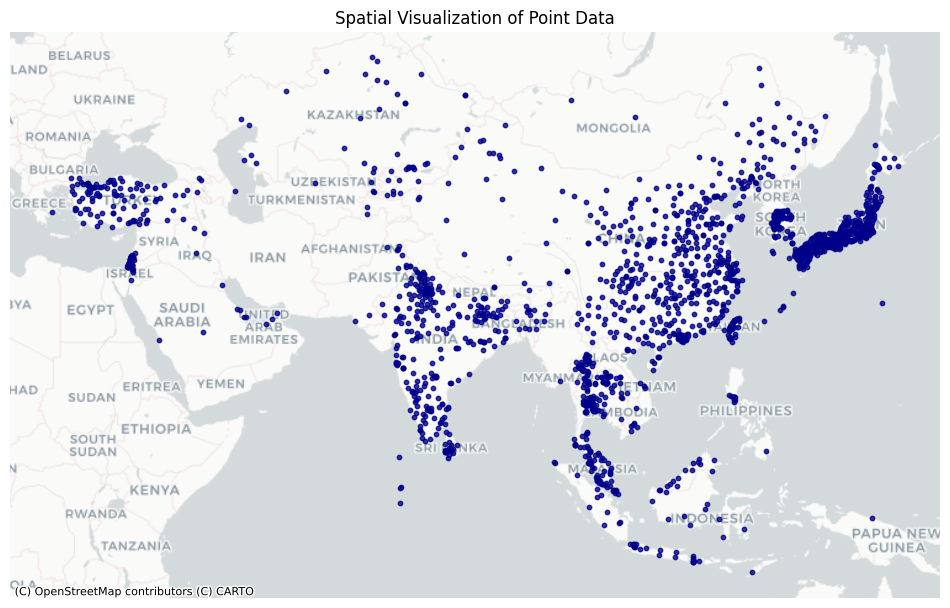

In [21]:
gdt_web = gdt.to_crs(epsg=3857)

ax = gdt_web.plot(figsize=(12, 10), color='darkblue', alpha=0.8, markersize=10)
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
plt.title("Spatial Visualization of Point Data")
plt.axis('off')
plt.show()

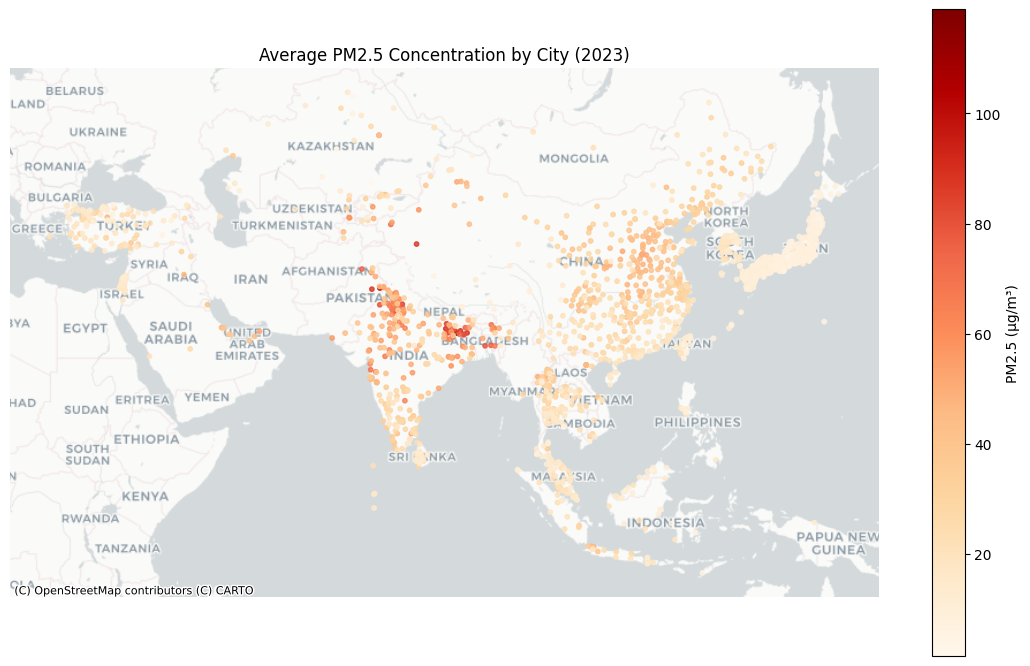

In [115]:
ax = gdt_web.plot(figsize=(14,12), column='2023', cmap='OrRd', legend=True, legend_kwds={'label': "PM2.5 (μg/m³)", 'shrink': 0.7},markersize = 10, alpha = 0.8)
cx.add_basemap(ax,source=cx.providers.CartoDB.Positron)
plt.title("Average PM2.5 Concentration by City (2023)")
plt.axis('off')
plt.show()

Spatial Locality of the point data

In [119]:
# Computing the spatial distance matrix using K-Nearest Neighbourhood
gdt = gdt.to_crs(epsg=3857)
coords = np.array([[point.x, point.y] for point in gdt.geometry])
weights = KNN.from_array(coords, k=10)
spat_dist_matrix = euclidean_distances(coords, coords)/1000
spat_dist_matrix = (spat_dist_matrix + spat_dist_matrix.T)/2

spat_dist_matrix_knn = np.zeros_like(spat_dist_matrix)
for i in range(len(gdt)):
    neighbors = list(weights.neighbors[i])
    for j in neighbors:
        if i<j:
            spat_dist_matrix_knn[i,j] = spat_dist_matrix[i,j]
            spat_dist_matrix_knn[j,i] = spat_dist_matrix[i,j]

spat_dist_matrix = spat_dist_matrix_knn

# Computing pairwise dissimilarity matrix in PM2.5 values
pm_values = gdt['2023'].values.reshape(-1,1)
pm_dist_matrix = euclidean_distances(pm_values, pm_values)
pm_dist_matrix = (pm_dist_matrix + pm_dist_matrix.T)/2

# Performing Mantel Test to check for correlation between the calculated matrices
mantel_coeff, p_value, n = mantel(spat_dist_matrix, pm_dist_matrix, method="pearson", permutations=2200)
print("Mantel statistic: ", mantel_coeff)
print("p-value: ", p_value)
print("Number of permutations actually done: ", n)

Mantel statistic:  -0.018977143314710107
p-value:  0.00045433893684688776
Number of permutations actually done:  2164


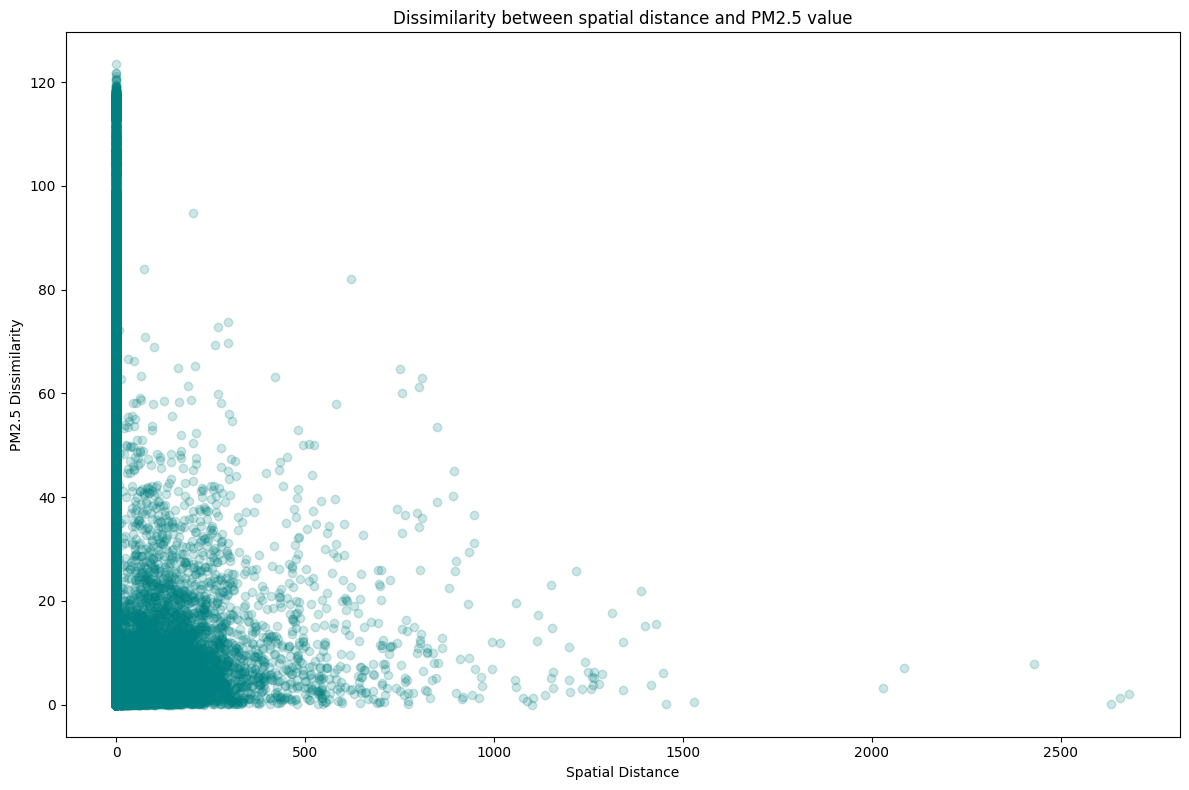

In [121]:
upper_tri_idx = np.triu_indices_from(spat_dist_matrix, k=1)
spat_distances = spat_dist_matrix[upper_tri_idx]
pm25_values = pm_dist_matrix[upper_tri_idx]

# Visual representation of the dissimilarity between the geometry(latitude, longitude) matrix and PM2.5 matrix
plt.figure(figsize=(12,8))
plt.scatter(spat_distances, pm25_values, alpha=0.2, color='teal')
plt.title('Dissimilarity between spatial distance and PM2.5 value')
plt.xlabel("Spatial Distance")
plt.ylabel("PM2.5 Dissimilarity")
plt.tight_layout()
plt.show()

Global Spatial Autocorrelation

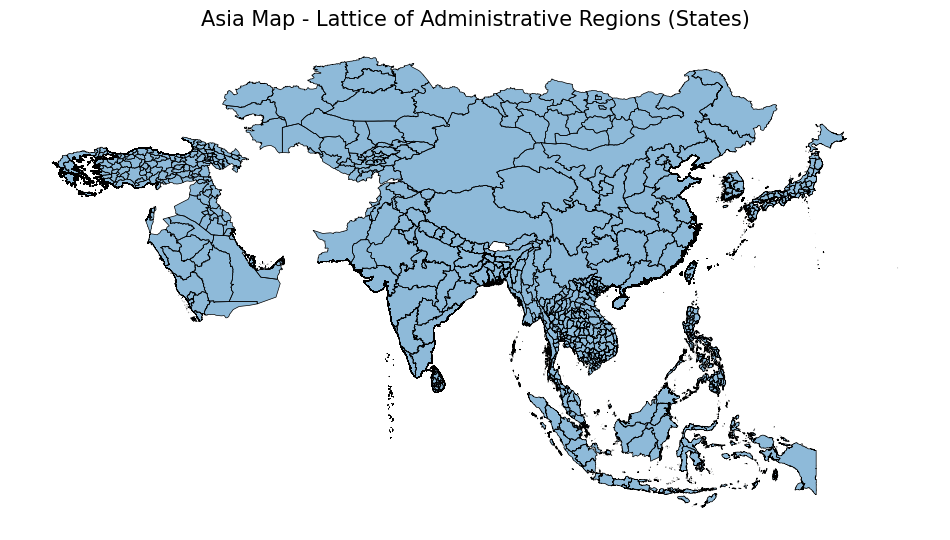

In [330]:
# Converting point data to lattice data

shapefile_paths = [
    'gadm41_ARE_shp/gadm41_ARE_1.shp',
    'gadm41_ARM_shp/gadm41_ARM_1.shp',
    'gadm41_AZE_shp/gadm41_AZE_1.shp',
    'gadm41_BGD_shp/gadm41_BGD_1.shp',
    'gadm41_BHR_shp/gadm41_BHR_1.shp',
    'gadm41_CHN_shp/gadm41_CHN_1.shp',
    'gadm41_GEO_shp/gadm41_GEO_1.shp',
    'gadm41_GRC_shp/gadm41_GRC_1.shp',
    'gadm41_IDN_shp/gadm41_IDN_1.shp',
    'gadm41_IND_shp/gadm41_IND_1.shp',
    'gadm41_IRQ_shp/gadm41_IRQ_1.shp',
    'gadm41_ISR_shp/gadm41_ISR_1.shp',
    'gadm41_JPN_shp/gadm41_JPN_1.shp',
    'gadm41_KAZ_shp/gadm41_KAZ_1.shp',
    'gadm41_KGZ_shp/gadm41_KGZ_1.shp',
    'gadm41_KHM_shp/gadm41_KHM_1.shp',
    'gadm41_KOR_shp/gadm41_KOR_1.shp',
    'gadm41_KWT_shp/gadm41_KWT_1.shp',
    'gadm41_LAO_shp/gadm41_LAO_1.shp',
    'gadm41_LKA_shp/gadm41_LKA_1.shp',
    'gadm41_MDV_shp/gadm41_MDV_0.shp',
    'gadm41_MMR_shp/gadm41_MMR_1.shp',
    'gadm41_MNG_shp/gadm41_MNG_1.shp',
    'gadm41_MYS_shp/gadm41_MYS_1.shp',
    'gadm41_NPL_shp/gadm41_NPL_1.shp',
    'gadm41_PAK_shp/gadm41_PAK_1.shp',
    'gadm41_PHL_shp/gadm41_PHL_1.shp',
    'gadm41_PSE_shp/gadm41_PSE_1.shp',
    'gadm41_QAT_shp/gadm41_QAT_1.shp',
    'gadm41_SAU_shp/gadm41_SAU_1.shp',
    'gadm41_SGP_shp/gadm41_SGP_1.shp',
    'gadm41_THA_shp/gadm41_THA_1.shp',
    'gadm41_TJK_shp/gadm41_TJK_1.shp',
    'gadm41_TUR_shp/gadm41_TUR_1.shp',
    'gadm41_TWN_shp/gadm41_TWN_1.shp',
    'gadm41_UZB_shp/gadm41_UZB_1.shp',
    'gadm41_VNM_shp/gadm41_VNM_1.shp',
]

gdf_list = []

for shp_path in shapefile_paths:
    gdf = gpd.read_file(shp_path)
    if 'geometry' in gdf.columns and gdf.geometry.geom_type.isin(['Polygon', 'MultiPolygon']).all():
        gdf_list.append(gdf)

# Combining into one Geoframe
all_regions = gpd.GeoDataFrame(pd.concat(gdf_list, ignore_index=True))
all_regions = all_regions.to_crs(epsg=4326)  

fig, ax = plt.subplots(figsize=(12, 10))
all_regions.boundary.plot(ax=ax, linewidth=0.5, edgecolor='black')
all_regions.plot(ax=ax, alpha=0.5)
ax.set_title("Asia Map - Lattice of Administrative Regions (States)", fontsize=15)
plt.axis("off")
plt.show()

In [323]:
joined = gpd.sjoin(gdt, all_regions, how='left', predicate='within')
print(joined[['geometry', '2023', 'NAME_1']])
region_pm25 = joined.groupby('NAME_1')['2023'].mean().reset_index()
region_gdf = all_regions[['NAME_1', 'geometry']]
region_gdf = region_gdf.merge(region_pm25, on='NAME_1', how='left')

                        geometry   2023          NAME_1
0      POINT (86.08834 25.51254)  118.9           Bihar
1       POINT (91.75394 26.1806)  105.4           Assam
2       POINT (77.1717 28.62739)  102.1    NCT of Delhi
3      POINT (76.36603 30.71916)  100.4          Punjab
4      POINT (74.31418 31.56568)   99.5          Punjab
...                          ...    ...             ...
2159   POINT (67.70618 47.79645)    4.3      Qaraghandy
2160  POINT (118.88479 -2.67563)    3.7  Sulawesi Barat
2161    POINT (32.52978 38.6548)    3.2           Konya
2162   POINT (70.18576 52.93875)    3.0          Aqmola
2163    POINT (73.0064 44.25848)    1.5         Zhambyl

[2164 rows x 3 columns]


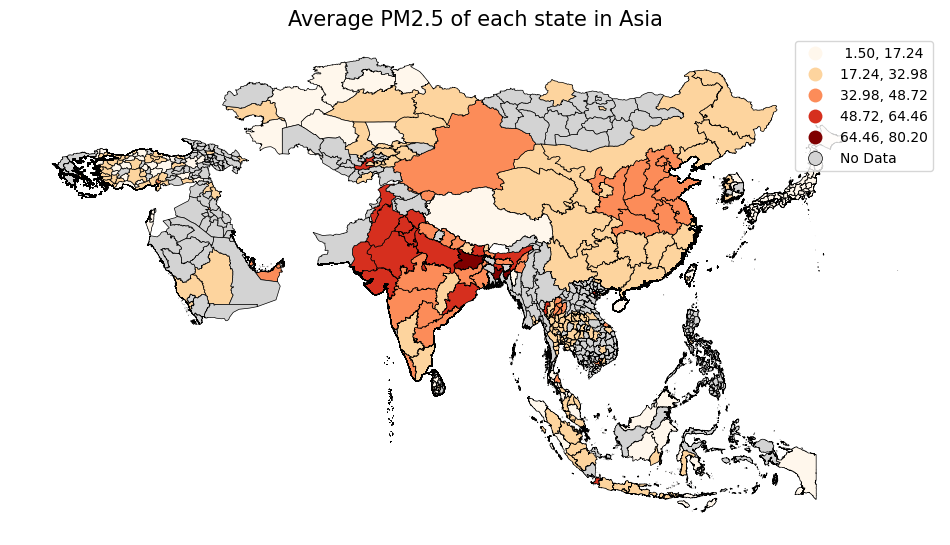

In [324]:
fig, ax = plt.subplots(figsize=(12, 10))
region_gdf.plot(column='2023',cmap='OrRd',scheme='equal_interval',k=5,legend=True,ax=ax,edgecolor='black',linewidth=0.5,
    missing_kwds={
        'color': 'lightgray',
        'label': 'No Data'
    }
)
ax.set_title('Average PM2.5 of each state in Asia', fontsize=15)
ax.axis('off')
plt.show()

Computing Moran's I

In [308]:
w = weights.Queen.from_dataframe(joined)
w.transform = 'r' 

moran = esda.Moran(joined['2023'].values, w)
print(f"Moran's I: {moran.I}")
print(f"p-value: {moran.p_sim}")
print("Expected value of Moran's I (E[I]): ", moran.EI)

Moran's I: 0.7786981072233888
p-value: 0.001
Expected value of Moran's I (E[I]):  -0.0004623208506703652


Computing Geary's c

In [312]:
geary = Geary(joined['2023'].values, w)
print("Geary's c: ", geary.C)
print("p-value: ", geary.p_sim)
print("Simulated expectation of Geary's C: ", geary.sim.mean())

Geary's c:  0.2176592126428353
p-value:  0.001
Simulated expectation of Geary's C:  0.9996142148452423


Location Indicators of Spatial Autocorrelation (LISA)
Using India as an example

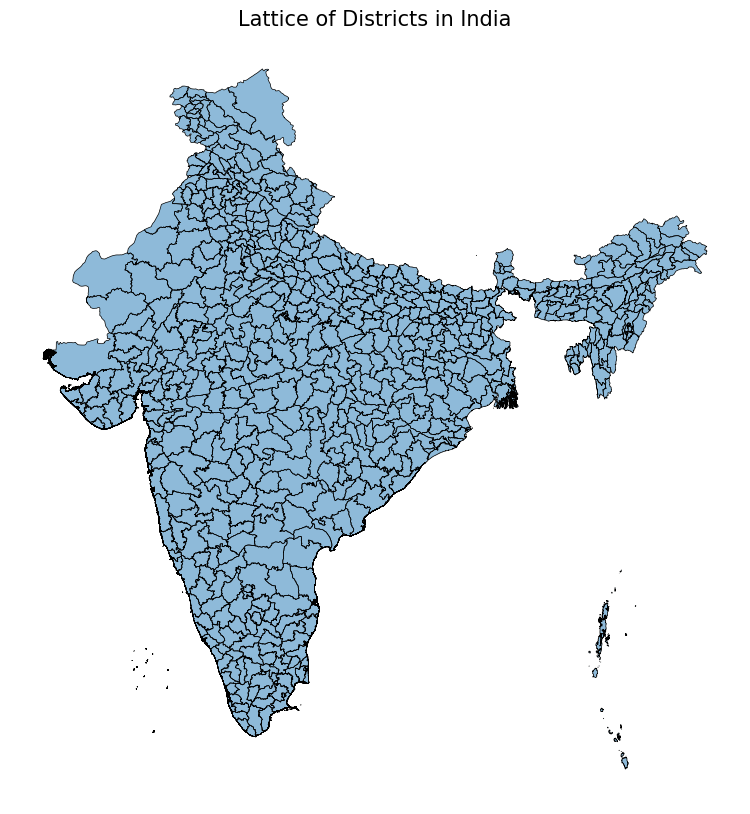

In [339]:
india_regions = gpd.read_file('gadm41_IND_shp/gadm41_IND_2.shp')
india_regions = india_regions.to_crs(epsg=4326)
fig, ax = plt.subplots(figsize=(12, 10))
india_regions.boundary.plot(ax=ax, linewidth=0.5, edgecolor='black')
india_regions.plot(ax=ax, alpha=0.5)
ax.set_title("Lattice of Districts in India", fontsize=15)
plt.axis("off")
plt.show()

In [368]:
joined_2 = gpd.sjoin(gdt, india_regions, how='left', predicate='within')
print(joined_2[['geometry', '2023', 'NAME_2']])
region_pm25_2 = joined_2.groupby('NAME_2')['2023'].mean().reset_index()
region_gdf_2 = india_regions[['NAME_2', 'geometry']]
region_gdf_2 = region_gdf_2.merge(region_pm25_2, on='NAME_2', how='left')

                        geometry   2023               NAME_2
0      POINT (86.08834 25.51254)  118.9            Begusarai
1       POINT (91.75394 26.1806)  105.4  Kamrup Metropolitan
2       POINT (77.1717 28.62739)  102.1                 West
3      POINT (76.36603 30.71916)  100.4      Fatehgarh Sahib
4      POINT (74.31418 31.56568)   99.5                  NaN
...                          ...    ...                  ...
2159   POINT (67.70618 47.79645)    4.3                  NaN
2160  POINT (118.88479 -2.67563)    3.7                  NaN
2161    POINT (32.52978 38.6548)    3.2                  NaN
2162   POINT (70.18576 52.93875)    3.0                  NaN
2163    POINT (73.0064 44.25848)    1.5                  NaN

[2164 rows x 3 columns]


In [383]:
data = joined_2.dropna(subset=['NAME_1']).reset_index(drop=True)
data = data.dropna(subset=['2023']).reset_index(drop=True)

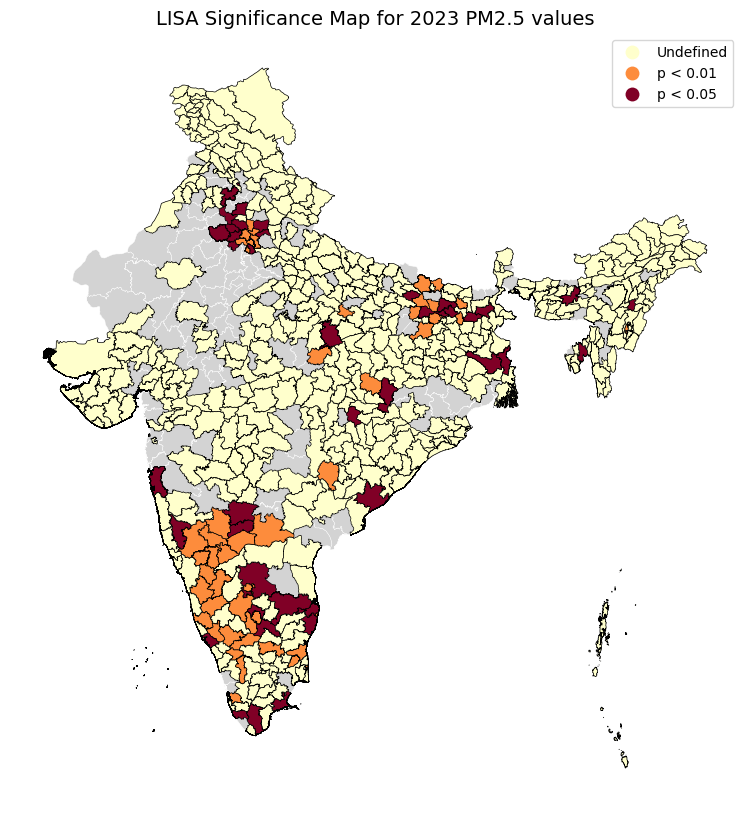

In [406]:
w_2 = weights.Queen.from_dataframe(data)
lisa_2 = Moran_Local(data['2023'].values, w_2)
data['Local_I'] = lisa_2.Is
data['p_value'] = lisa_2.p_sim
data['quadrant'] = lisa_2.q

region_gdf_2['cluster_label'] = region_gdf_2['cluster']
cluster_counts = region_gdf_2['cluster_label'].value_counts()
region_gdf_2['cluster_label'] = region_gdf_2['cluster_label'].map(
    lambda x: f"{x} ({cluster_counts.get(x, 0)})"
)

fig, ax = plt.subplots(1, figsize=(12, 10))
region_gdf_2.plot(
    ax=ax,
    color='lightgrey',
    edgecolor='white',
    linewidth=0.3
)

region_gdf_2[region_gdf_2['significance'] != 'Not Significant'].plot(
    ax=ax,
    column='significance',
    categorical=True,
    legend=True,
    cmap='YlOrRd',
    edgecolor='black',
    linewidth=0.5
)

ax.set_title("LISA Significance Map for 2023 PM2.5 values", fontsize=14)
ax.axis('off')
plt.show()

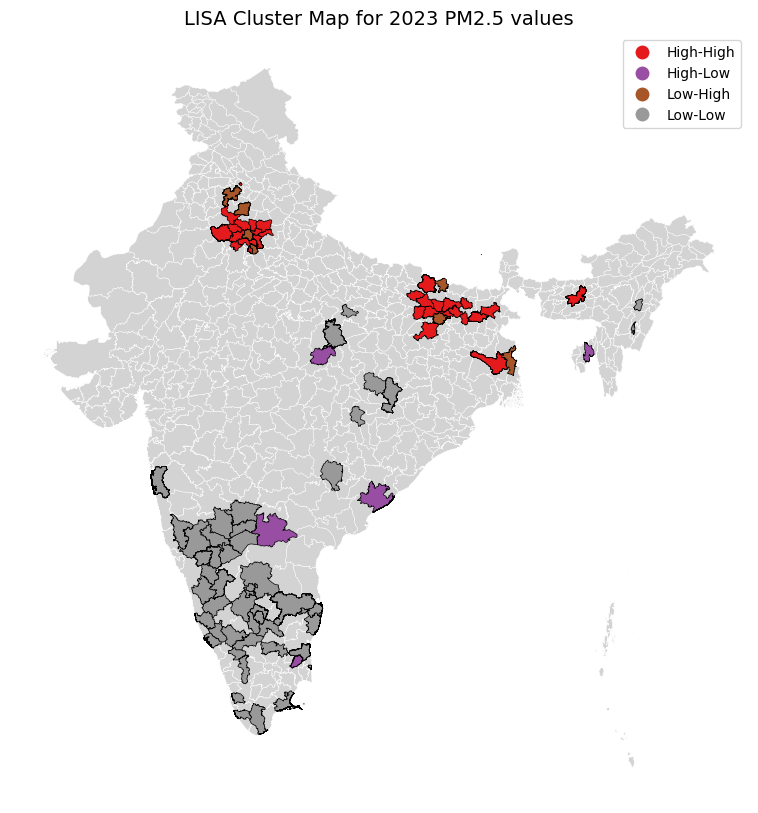

In [407]:
region_gdf_2['significance'] = 'Not Significant'
region_gdf_2.loc[region_gdf_2['p_value']<0.05, 'significance'] = 'p < 0.05'
region_gdf_2.loc[region_gdf_2['p_value']<0.01, 'significance'] = 'p < 0.01'
region_gdf_2.loc[region_gdf_2['p_value']<0.001, 'significance'] = 'p < 0.001'
region_gdf_2.loc[region_gdf_2['NAME_2'].isin([region_gdf_2.iloc[i]['NAME_2'] for i in isolates]), 'significance'] = 'Neighborless'
region_gdf_2.loc[region_gdf_2['2023'].isna(), 'significance'] = 'Undefined'

ig, ax = plt.subplots(1, figsize=(12, 10))
region_gdf_2.plot(
    ax=ax,
    color='lightgrey',
    edgecolor='white',
    linewidth=0.3
)
region_gdf_2[region_gdf_2['cluster'] != 'Not Significant'].plot(
    ax=ax,
    column='cluster',
    categorical=True,
    legend=True,
    cmap='Set1',
    edgecolor='black',
    linewidth=0.5
)
ax.set_title("LISA Cluster Map for 2023 PM2.5 values", fontsize=14)
ax.axis('off')
plt.show()

Getis-ord Statistics

In [418]:
w_g = Queen.from_dataframe(data)
w_g.transform = 'r'

glocal = G_Local(data['2023'], w_g)
data['GiZScore'] = glocal.Zs
data['GiPValue'] = glocal.p_sim

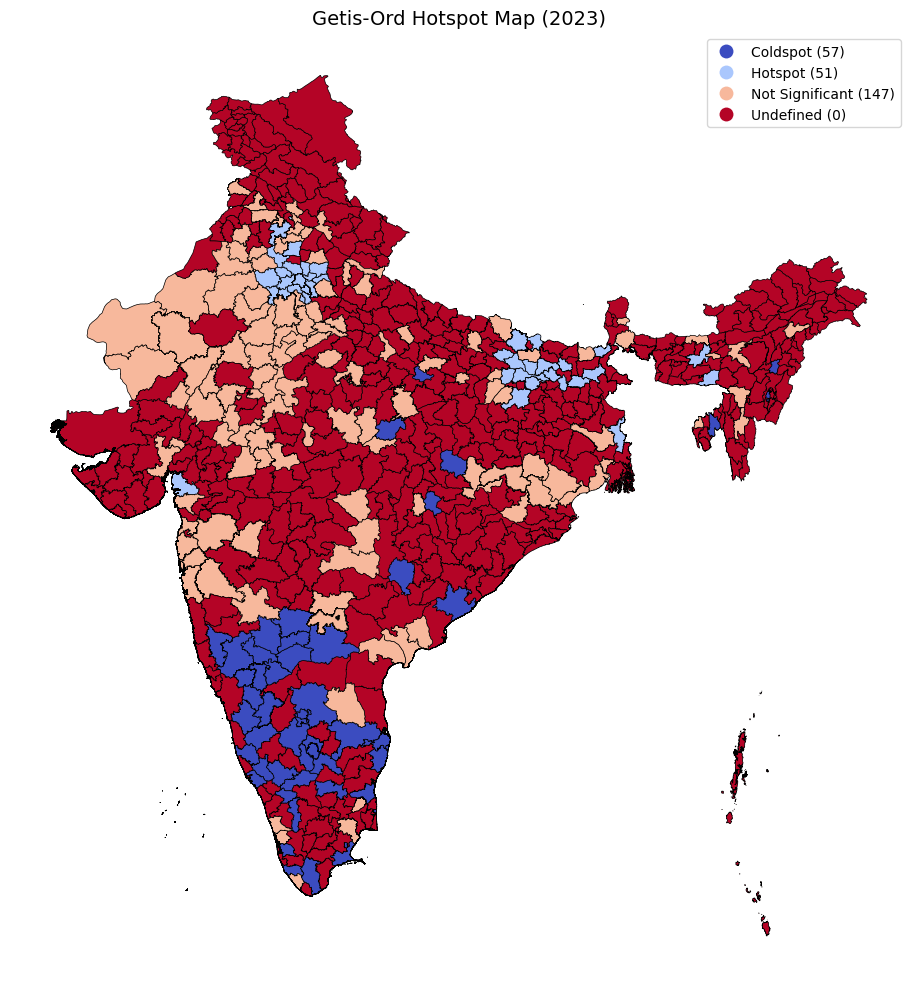

In [419]:
def classify(z,p):
    if p<0.05:
        if z>0:
            return 'Hotspot'
        elif z<0:
            return 'Coldspot'
    return 'Not Significant' 

data['class'] = [
    classify(z,p) for z,p in zip(data['GiZScore'], data['GiPValue'])
]

region_gdf_2['hotspot_label'] = region_gdf_2['hotspot_label'].fillna('Undefined (0)')

fig, ax = plt.subplots(1, figsize=(12, 10))
region_gdf_2.plot(
    ax=ax,
    color='lightgrey',
    edgecolor='white',
    linewidth=0.3
)

region_gdf_2[region_gdf_2['hotspot_label'] != 'Not Significant'].plot(
    ax=ax,
    column='hotspot_label',
    categorical=True,
    legend=True,
    cmap='coolwarm',
    edgecolor='black',
    linewidth=0.5
)
ax.set_title("Getis-Ord Hotspot Map (2023)", fontsize=14)
ax.axis('off')
plt.tight_layout()
plt.show()

Global Moran Scatterplot

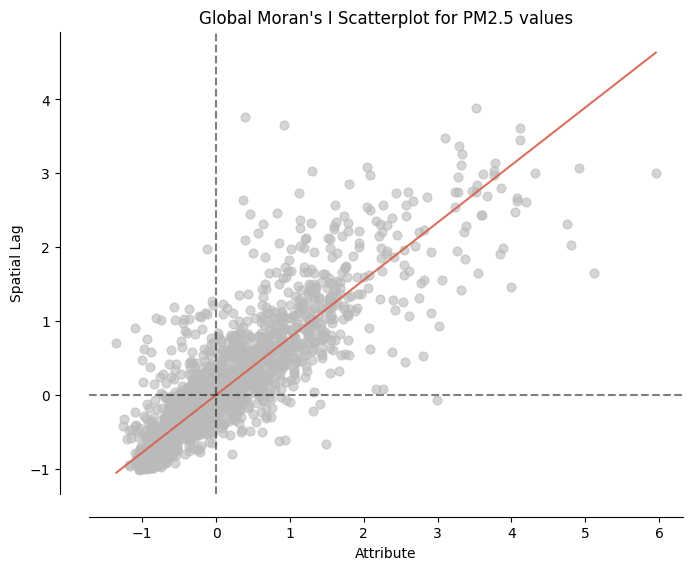

In [420]:
fig, ax = plt.subplots(1, figsize=(8,6))
esdaplot.moran_scatterplot(moran, ax=ax)
ax.set_title("Global Moran's I Scatterplot for PM2.5 values")
plt.show()

Spatial Correlogram

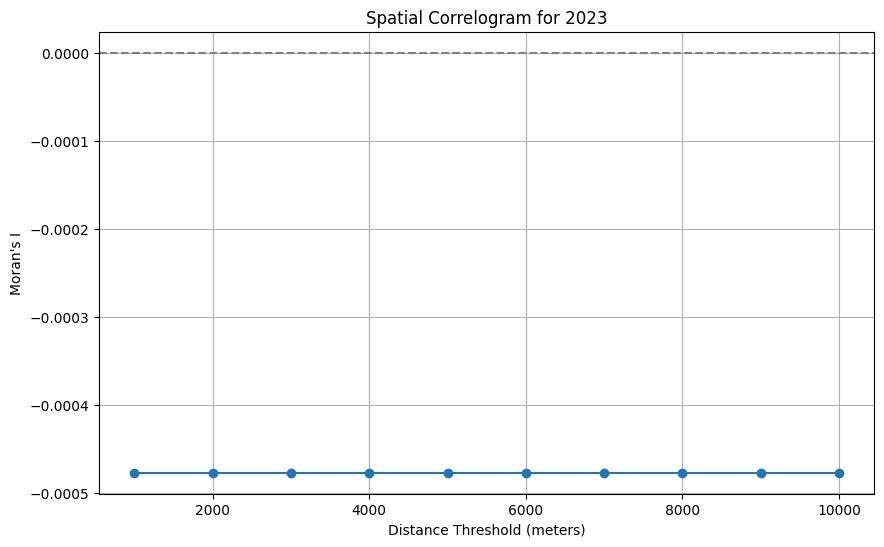

In [423]:
coords_2 = np.array(list(joined.geometry.centroid.apply(lambda geom: (geom.x, geom.y))))

max_dist = 10000
step = 1000
lags = list(range(step,max_dist+step,step))

moran_vals = []

for dist in lags:
    w_dist = DistanceBand(coords_2, threshold=dist, binary=True, silence_warnings=True)
    w_dist.transform = 'r'
    moran_w = Moran(joined['2023'], w_dist)
    moran_vals.append(moran_w.I)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(lags, moran_vals, marker='o', linestyle='-')
ax.axhline(0, color='grey', linestyle='--')
ax.set_xlabel('Distance Threshold (meters)')
ax.set_ylabel("Moran's I")
ax.set_title("Spatial Correlogram for 2023")
plt.grid(True)
plt.show()

Q-Statistic

In [429]:
def q_stats(df, val_col, group_col):
    variance_df = df[val_col].var(ddof=0)
    N = len(df)
    grouped = df.groupby(group_col)
    intra_strata_var = 0
    for _, group in grouped:
        if len(group) > 1:
            intra_strata_var+= len(group) * group[val_col].var(ddof=0)
    
    Q = 1 - (intra_strata_var/(N*variance_df))
    return Q

Q = q_stats(data, val_col='2023', group_col='hotspot_label')
print("Q-Statistic: ", Q)

Q-Statistic:  0.3569745512541217


Geographically Weighted Regression

In [436]:
joined = joined.to_crs(epsg=3857)

In [442]:
coords_gwr = np.column_stack([joined.geometry.centroid.x, joined.geometry.centroid.y])
y = joined[['2023']].values
X = joined[['Apr', 'Jul']]

X = StandardScaler().fit_transform(X)

bw = Sel_BW(coords_gwr, y, X).search()
print("Optimal Bandwidth: ", bw)

gwr_model = GWR(coords_gwr, y, X, bw)
gwr_res = gwr_model.fit()
print(gwr_res.summary())

Optimal Bandwidth:  50.0
Model type                                                         Gaussian
Number of observations:                                                2164
Number of covariates:                                                     3

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                         173195.348
Log-likelihood:                                                   -7812.407
AIC:                                                              15630.813
AICc:                                                             15632.832
BIC:                                                             156599.486
R2:                                                                   0.690
Adj. R2:                                                              0.690

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---

Kernel Density Estimation

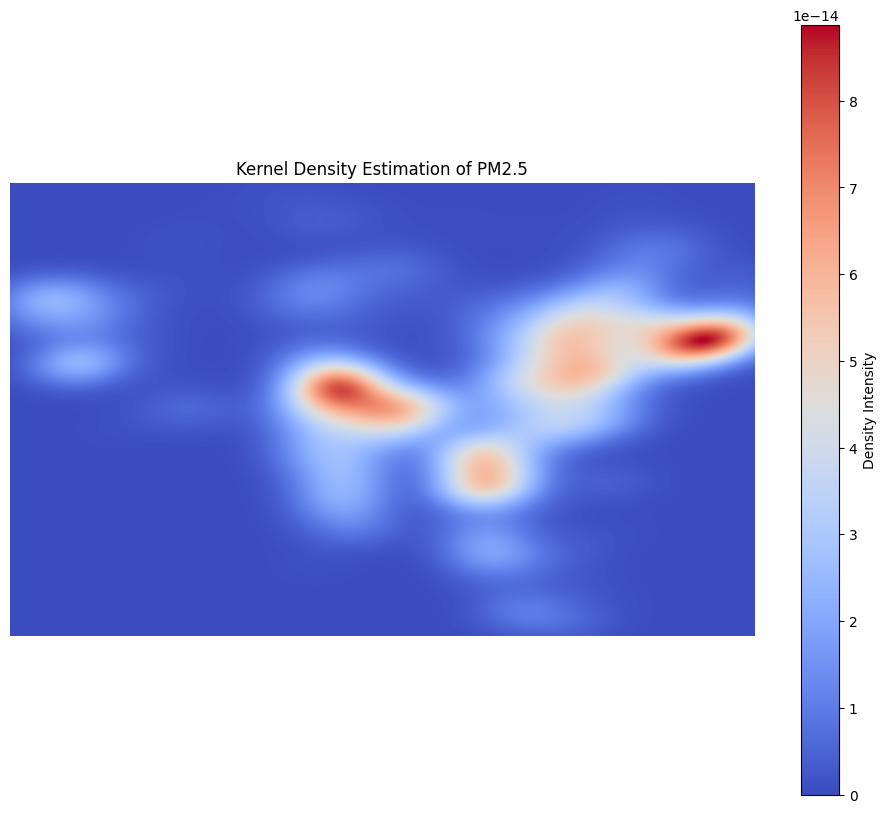

In [ ]:
coords_kde = np.vstack([joined.geometry.x, joined.geometry.y])
weights_kde = joined['2023']

kde = gaussian_kde(coords_kde,  weights= weights_kde, bw_method=0.2)
xmin, xmax = coords_kde[0].min(), coords_kde[0].max()
ymin, ymax = coords_kde[1].min(), coords_kde[1].max()

X,Y = np.mgrid[xmin:xmax:1000j, ymin:ymax:1000j]
pos = np.vstack([X.ravel(), Y.ravel()])
Z = np.reshape(kde(pos).T, X.shape)

fig, ax = plt.subplots(figsize=(12,10))
cax = ax.imshow(np.rot90(Z), cmap='coolwarm', extent=[xmin, xmax, ymin, ymax])
joined.boundary.plot(ax=ax, color='blue', linewidth=0.5)
fig.colorbar(cax, ax=ax, orientation='vertical', label='Density Intensity')
ax.set_title('Kernel Density Estimation of PM2.5')
ax.set_axis_off()
plt.show()

Histogram Estimation using Smooth Kernel Histogram

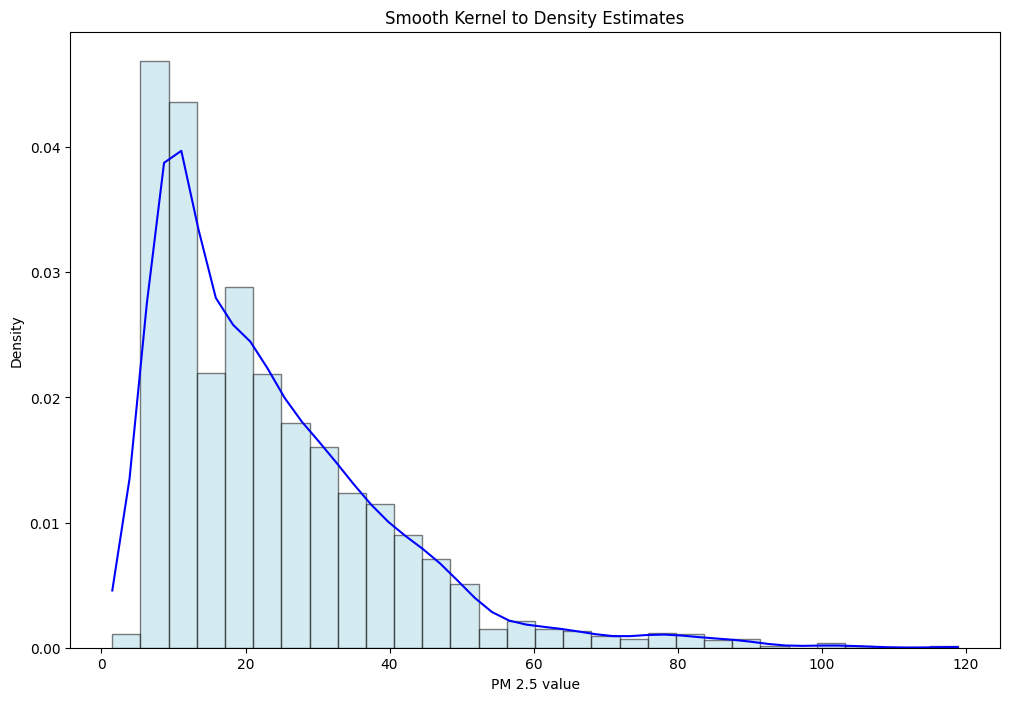

In [451]:
pm_values_2023 = joined['2023']
xmin_kde, xmax_kde = pm_values_2023.min(), pm_values_2023.max()
x = np.linspace(xmin_kde, xmax_kde)
kde_smooth = gaussian_kde(pm_values_2023, bw_method='scott')
y_smooth = kde_smooth(x)
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(x, y_smooth, color='blue', label='Box Kernel Density')
ax.hist(pm_values_2023, bins=30, density=True, color='lightblue', edgecolor='black', alpha=0.5, label='Histogram')
ax.set_title('Smooth Kernel to Density Estimates')
ax.set_xlabel('PM 2.5 value')
ax.set_ylabel('Density')
plt.show()

Interpolation using Kriging

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'spherical' Variogram Model
Partial Sill: 181.32669951501245
Full Sill: 426.5095011328908
Range: 20.31799663634805
Nugget: 245.18280161787837 



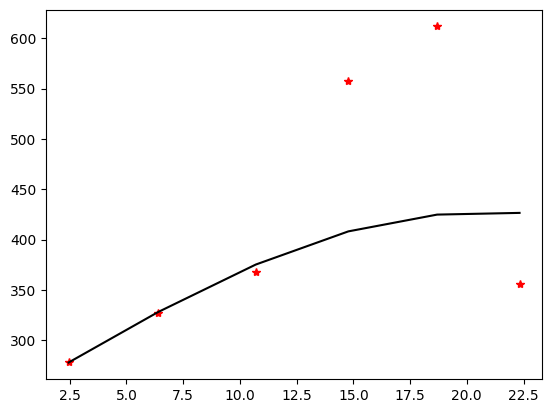

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...



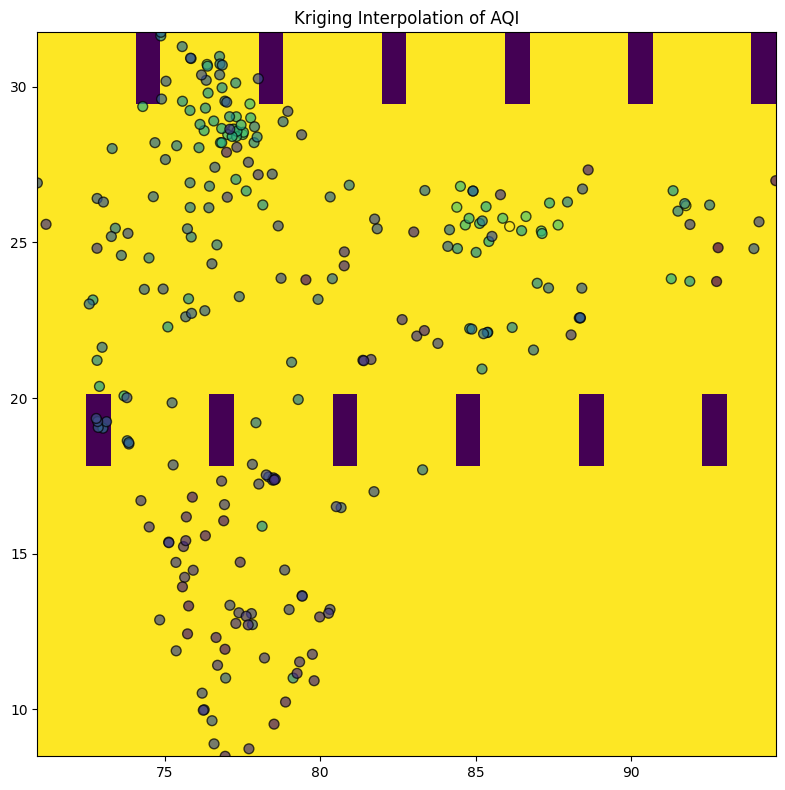

In [470]:
coords = np.array([data.geometry.x, data.geometry.y]).T
values = data['2023'].values    
grid_x, grid_y = np.mgrid[min(data.geometry.x):max(data.geometry.x):30j,min(data.geometry.y):max(data.geometry.y):20j]

ok = OrdinaryKriging(coords[:, 0], coords[:, 1], values, variogram_model='spherical',verbose=True, enable_plotting=True)
grid_x_kriging, ss = ok.execute('grid', grid_x[0,:], grid_y[:,0])

fig, ax = plt.subplots(figsize=(14, 8))
ax.imshow(grid_x_kriging.T,extent=(min(data.geometry.x), max(data.geometry.x),min(data.geometry.y), max(data.geometry.y)), origin='lower', cmap = 'viridis')
ax.scatter(data.geometry.x, data.geometry.y, c=data['2023'], s=50, edgecolor='k', alpha=0.7)
ax.set_title('Kriging Interpolation of AQI')
plt.tight_layout()
plt.show()

Spatial Stationarity